In [ ]:
from google.colab import drive
drive.mount("./drive")

Mounted at ./drive


In [ ]:
!pip install pyssim

In [ ]:
!wget https://www.ieee.org/content/dam/ieee-org/ieee/web/org/conferences/conference-template-letter.docx

--2023-12-03 06:25:49--  https://www.ieee.org/content/dam/ieee-org/ieee/web/org/conferences/conference-template-letter.docx
Resolving www.ieee.org (www.ieee.org)... 23.39.7.88
Connecting to www.ieee.org (www.ieee.org)|23.39.7.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: AWSELBCORS=55B9EFD71A621664217649CC5C38F09A66B8CD41098F3D56379851DC886A0366123E7C88ADFDA49E920AFE49EFC4DCFD91A39FD99AA4B1E09EC960E71995097EB293C2DDCA;PATH=/;MAX-AGE=900;SECURE;; SameSite=None; Secure; at position 176.
Length: 30516 (30K) [application/vnd.openxmlformats-officedocument.wordprocessingml.document]
Saving to: ‘conference-template-letter.docx’

conference-template 100%[===================>]  29.80K  --.-KB/s    in 0.01s   

2023-12-03 06:25:49 (2.84 MB/s) - ‘conference-template-letter.docx’ saved [30516/30516]



In [ ]:
import cv2
from skimage.util import random_noise
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from ssim import SSIM #!pip install pyssim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float
from tqdm import tqdm


In [ ]:
# Gt_img - 4 different noise img
# two denoising also d1, d2

In [ ]:
## Function to generate all noisy images

def img_gen(img):
  sigma = 0.05
  var = sigma**2
  return {
      "gaus": random_noise(img, mode='gaussian', seed=None, clip=True, var=var),
      "pois": random_noise(img, mode='poisson', seed=None, clip=True),
      "sp": random_noise(img, mode='s&p', seed=None, clip=True),
      "spk": random_noise(img, mode='speckle', seed=None, clip=True, var=var)
  }


## Function to denoise generate noisy image using two differet algo


def denoised_img(img_obj):
  denoised_img_obj = {}
  for img_name in img_obj:
    d1 = denoise_bilateral(img_obj[img_name], sigma_color=0.05, sigma_spatial=15,
                channel_axis=-1)
    d2 = denoise_wavelet(img_obj[img_name], channel_axis=-1, rescale_sigma=True)
    denoised_img_obj[img_name] = [d1, d2]

  return denoised_img_obj

## Function to calcurate SSIM
def calculate_ssim(rgb_image1, rgb_image2):
    # Ensure the images have the same shape
    if rgb_image1.shape != rgb_image2.shape:
        raise ValueError("Input images must have the same shape")

    # Calculate SSIM for each color channel
    ssim_r = ssim(rgb_image1[:,:,0], rgb_image2[:,:,0], multichannel=False)
    ssim_g = ssim(rgb_image1[:,:,1], rgb_image2[:,:,1], multichannel=False)
    ssim_b = ssim(rgb_image1[:,:,2], rgb_image2[:,:,2], multichannel=False)

    # Calculate the average SSIM across all color channels
    average_ssim = np.mean([ssim_r, ssim_g, ssim_b])

    return average_ssim


def cal_cw_ssim(img, d_img):
    img = Image.fromarray(np.uint8(img)).convert('RGB')
    noisy = Image.fromarray(np.uint8(d_img)).convert('RGB')
    return SSIM(img).cw_ssim_value(noisy)

def cal_IQA(img, denoised_img_obj):
    iqa_list = {
        "gaus": {},
        "pois": {},
        "sp": {},
        "spk": {}}

    for i in denoised_img_obj:
      d1 = {}
      d2 = {}

      d1["psnr"] = psnr(img, denoised_img_obj[i][0])
      d1["ssim"] = calculate_ssim(img, denoised_img_obj[i][0])
      d1["cw-ssim"] = cal_cw_ssim(img, denoised_img_obj[i][0])

      d2["psnr"] = psnr(img, denoised_img_obj[i][1])
      d2["ssim"] = calculate_ssim(img, denoised_img_obj[i][1])
      d2["cw-ssim"] = cal_cw_ssim(img, denoised_img_obj[i][1])

      iqa_list[i]["d1"] = d1
      iqa_list[i]["d2"] = d2

    return iqa_list


def save_sidd_img(dir_path, img_path, denoise_img, img):
  final_path = os.path.join(dir_path, img_path.split("/")[-2])

  if not os.path.exists(final_path):
      os.makedirs(final_path)

  for i in denoise_img:
    plt.imsave(f'{final_path}/{i}_d1.png', denoise_img[i][0])
    try:
      plt.imsave(f'{final_path}/{i}_d2.png', img_as_float(denoise_img[i][1]))
    except:
      # print(f'Error - {i}')
      min_value = np.min(denoise_img[i][1])
      max_value = np.max(denoise_img[i][1])
      normalized_image = (denoise_img[i][1] - min_value) / (max_value - min_value)
      plt.imsave(f'{final_path}/{i}_d2.png', normalized_image)

  plt.imsave(f'{final_path}/original.png', img)


def save_set12_img(dir_path, img_path, denoise_img, img):
  final_path = os.path.join(dir_path, img_path.split("/")[-1].split(".")[0])

  if not os.path.exists(final_path):
      os.makedirs(final_path)

  for i in denoise_img:
    plt.imsave(f'{final_path}/{i}_d1.png', denoise_img[i][0])
    try:
      plt.imsave(f'{final_path}/{i}_d2.png', img_as_float(denoise_img[i][1]))
    except:
      # print(f'Error - {i}')
      min_value = np.min(denoise_img[i][1])
      max_value = np.max(denoise_img[i][1])
      normalized_image = (denoise_img[i][1] - min_value) / (max_value - min_value)
      plt.imsave(f'{final_path}/{i}_d2.png', normalized_image)

  plt.imsave(f'{final_path}/original.png', img)

def save_cure_tsr_img(dir_path, img_path, denoise_img, img):
  final_path = os.path.join(dir_path, "_".join(img_path.split("/")[2:]).split(".")[0])
  # print(final_path)
  if not os.path.exists(final_path):
      os.makedirs(final_path)

  for i in denoise_img:
    plt.imsave(f'{final_path}/{i}_d1.png', denoise_img[i][0])
    try:
      plt.imsave(f'{final_path}/{i}_d2.png', img_as_float(denoise_img[i][1]))
    except:
      # print(f'Error - {i}')
      min_value = np.min(denoise_img[i][1])
      max_value = np.max(denoise_img[i][1])
      normalized_image = (denoise_img[i][1] - min_value) / (max_value - min_value)
      plt.imsave(f'{final_path}/{i}_d2.png', normalized_image)

  plt.imsave(f'{final_path}/original.png', img)


def process_img(img_path, save_dir, dataset_type):
  img = cv2.imread(img_path)
  if dataset_type == "sidd":
    img = img[0:50, 0:50]

  noisiy_img = img_gen(img)

  denoise_img = denoised_img(noisiy_img)
  if dataset_type == "sidd":
    img_name = img_path.split("Data")[-1]
  elif dataset_type == "set12":
    img_name = img_path.split("/")[-1].split(".")[0]
  elif dataset_type == "Cure_TSR":
    img_name = "_".join(img_path.split("/")[2:-1])

  save_dir = save_dir #"/content/drive/MyDrive/DIP/dataset/SIDD_medium/all_SIDD_img_M"

  if dataset_type == "sidd":
    save_sidd_img(save_dir, img_path, denoise_img, img)
  elif dataset_type == "set12":
    save_set12_img(save_dir, img_path, denoise_img, img)
  elif dataset_type == "Cure_TSR":
    save_cure_tsr_img(save_dir, img_path, denoise_img, img)

  return img_name, cal_IQA(img, denoise_img)

In [ ]:
########## Code for Set 12 Dataset
import os
dir_path = "/content/drive/MyDrive/DIP/dataset/mini_CURE_OR/train"
# save_path = "/content/drive/MyDrive/DIP/dataset/set_12/all_set12_img"

img_folder_path_list =[os.path.join(dir_path, i) for i in os.listdir(dir_path)]


In [ ]:
!unzip /content/drive/MyDrive/DIP/dataset/CURE-TSR.zip

Archive:  /content/drive/MyDrive/DIP/dataset/CURE-TSR.zip
 extracting: Unreal_Train.zip        
 extracting: Real_Train.zip          
 extracting: Unreal_Test.zip         
 extracting: Real_Test.zip           


In [ ]:
!unzip /content/Real_Test.zip

In [ ]:
import os
dir_path = "/content/Real_Test"
dir_path2 = "/content/Unreal_Train"

save_path = "/content/drive/MyDrive/DIP/dataset/Cure_TSR/all_CURE_TSR_data"

folder_list1 = [os.path.join(dir_path, i) for i in os.listdir(dir_path)]
# folder_list2 = [os.path.join(dir_path2, i) for i in os.listdir(dir_path2)]

In [ ]:
img_folder_path_list = []
for j in folder_list1:
  new_ = [os.path.join(j, i) for i in os.listdir(j)]
  print(j, len(new_))
  img_folder_path_list.extend(new_)

In [ ]:
len(img_folder_path_list)

203374

In [ ]:
img = cv2.imread("/content/Real_Test/CodecError-1/01_01_03_01_0001.bmp")

In [ ]:
img2 = cv2.imread("/content/Real_Test/ChallengeFree/01_01_03_01_0001.bmp")

In [ ]:
!unzip /content/drive/MyDrive/DIP/dataset/CURE-TSR.zip -d /content/drive/MyDrive/DIP/dataset/Cure_TSR

Archive:  /content/drive/MyDrive/DIP/dataset/CURE-TSR.zip
 extracting: /content/drive/MyDrive/DIP/dataset/Cure_TSR/Unreal_Train.zip  
 extracting: /content/drive/MyDrive/DIP/dataset/Cure_TSR/Real_Train.zip  
 extracting: /content/drive/MyDrive/DIP/dataset/Cure_TSR/Unreal_Test.zip  
 extracting: /content/drive/MyDrive/DIP/dataset/Cure_TSR/Real_Test.zip  


In [ ]:
!unzip /content/drive/MyDrive/DIP/dataset/Cure_TSR/Real_Train.zip

In [ ]:
########## Code for Set 12 Dataset
import os
dir_path = "/content/Real_Train"
dir_path2 = "/content/Unreal_Train"

save_path = "/content/drive/MyDrive/DIP/dataset/Cure_TSR/all_CURE_TSR_data"

folder_list1 = [os.path.join(dir_path, i) for i in os.listdir(dir_path)]
folder_list2 = [os.path.join(dir_path2, i) for i in os.listdir(dir_path2)]

img_folder_path_list = []
for j in folder_list1:
  img_folder_path_list.extend([os.path.join(j, i) for i in os.listdir(j)])

for j in folder_list2:
  img_folder_path_list.extend([os.path.join(j, i) for i in os.listdir(j)])

In [ ]:
dataset_type = "Cure_TSR" # set12 | sidd | Cure_TSR

dataset_obj = {
    "img_name" : [],
    "values": []
}

for i in tqdm(img_folder_path_list):
  # print("_".join(i.split("/")[2:]).split(".")[0])
  img_name, values = process_img(i, save_path, dataset_type)
  dataset_obj["img_name"].append(img_name)
  dataset_obj["values"].append(values)


In [ ]:
# from time import sleep

# for i in tqdm(img_folder_path_list):
#   print(i)
#   sleep(1)

In [ ]:
"_".join(img_folder_path_list[0].split("/")[2:]).split(".")[0]

'Real_Train_Snow-2_01_02_11_02_0176'

In [ ]:
## Code for CURE-TSR

In [ ]:
import os
dir_path = "/content/Real_Test"
dir_path2 = "/content/Unreal_Train"

save_path = "/content/drive/MyDrive/DIP/dataset/Cure_TSR/all_CURE_TSR_data"

folder_list1 = [os.path.join(dir_path, i) for i in os.listdir(dir_path)]
img_folder_path_list = []
for j in folder_list1:
  if j != '/content/Real_Test/ChallengeFree':
    img_folder_path_list.extend([os.path.join(j, i) for i in os.listdir(j)][:100])

In [ ]:
len(img_folder_path_list)

6000

In [ ]:
len(img_folder_path_list)

12000

In [ ]:
img_folder_path_list[0]

'/content/Real_Test/Darkening-4/01_14_04_04_0522.bmp'

In [ ]:
img_folder_path_list[0].split("/")[-1]

'01_14_04_04_0522.bmp'

In [ ]:
class_name = img_folder_path_list[0].split("/")[-2]
img_name = img_folder_path_list[0].split("/")[-1]

In [ ]:
class_name

'Darkening-4'

In [ ]:
img_name

'01_14_04_04_0522.bmp'

In [ ]:
gt_folder = "/content/Real_Test/ChallengeFree/"

In [ ]:
save_folder = "/content/drive/MyDrive/DIP/dataset/CURE_TSR/r1"

In [ ]:
import json

In [ ]:
res = {
    "img_name": [],
    "psnr_d1" : [],
    "ssim_d1": [],
    "cw-ssim_d1": [],
    "psnr_d2" : [],
    "ssim_d2": [],
    "cw-ssim_d2": [],
}

In [ ]:
class_name = i.split("/")[-2]
img_name = i.split("/")[-1]

gt_img_name = "01_"+img_name.split(".")[0].split("_")[1] +"_00_00_" + img_name.split(".")[0].split("_")[-1] + ".bmp"
# print(gt_folder + gt_img_name, i)
gt_img = cv2.imread(gt_folder + gt_img_name)
img = cv2.imread(i)

In [ ]:
class_name = img_folder_path_list[0].split("/")[-2]
img_name = img_folder_path_list[0].split("/")[-1]

gt_img_name = "01_"+img_name.split(".")[0].split("_")[1] +"_00_00_" + img_name.split(".")[0].split("_")[-1] + ".bmp"
# print(gt_folder + gt_img_name, i)
gt_img = cv2.imread(gt_folder + gt_img_name)
img = cv2.imread(i)

gt_img = np.float64(gt_img)
# img = img/255 #(img - np.min(img)) / (np.max(img) - np.min(img))
# gt_img = gt_img/255 #(gt_img - np.min(gt_img)) / (np.max(gt_img) - np.min(gt_img))

d1 = denoise_bilateral(img, sigma_color=0.05, sigma_spatial=15,
              channel_axis=-1)
d2 = denoise_wavelet(img, channel_axis=-1, rescale_sigma=True)

In [ ]:
type(gt_img[0][0][0])

numpy.float64

In [ ]:
psnr(gt_img, d1, data_range=gt_img.max() - gt_img.min())

3.526549469134408

In [ ]:
for i in tqdm(img_folder_path_list):
  class_name = i.split("/")[-2]
  img_name = i.split("/")[-1]

  gt_img_name = "01_"+img_name.split(".")[0].split("_")[1] +"_00_00_" + img_name.split(".")[0].split("_")[-1] + ".bmp"
  # print(gt_folder + gt_img_name, i)
  gt_img = cv2.imread(gt_folder + gt_img_name)
  img = cv2.imread(i)
  # if gt_img == None:
  #   print(gt_folder + img_name, i)
  #   continue

  # img = img/255 #(img - np.min(img)) / (np.max(img) - np.min(img))
  gt_img = gt_img/255 #(gt_img - np.min(gt_img)) / (np.max(gt_img) - np.min(gt_img))
  # print(img[0][0][0], gt_img[0][0][0])
  d1 = denoise_bilateral(img, sigma_color=0.05, sigma_spatial=15,
                channel_axis=-1)
  d2 = denoise_wavelet(img, channel_axis=-1, rescale_sigma=True)
  # print(d1)
  final_path = os.path.join(save_folder, "_".join([class_name, img_name.split(".")[0]]))
  # print(final_path)
  if not os.path.exists(final_path):
      os.makedirs(final_path)

  plt.imsave(f'{final_path}/original.png', gt_img)
  plt.imsave(f'{final_path}/d1.png', d1)
  plt.imsave(f'{final_path}/d2.png', d2)

  res["img_name"].append("_".join([class_name, img_name]))
  # print(gt_img.shape, d1.shape, img.shape)
  res["psnr_d1"].append(psnr(gt_img, d1))
  res["psnr_d2"].append(psnr(gt_img, d2))

  res["ssim_d1"].append(calculate_ssim(gt_img, d1))
  res["ssim_d2"].append(calculate_ssim(gt_img, d2))

  res["cw-ssim_d1"].append(cal_cw_ssim(gt_img, d1))
  res["cw-ssim_d2"].append(cal_cw_ssim(gt_img, d2))

  # print(res)
  # break
  with open("/content/drive/MyDrive/DIP/dataset/CURE_TSR/CURE_TSR_real_final.json", "w") as write_file:
        json.dump(res, write_file)


  0%|          | 0/6000 [00:00<?, ?it/s]<ipython-input-4-11a21fdabb62>:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_r = ssim(rgb_image1[:,:,0], rgb_image2[:,:,0], multichannel=False)
<ipython-input-4-11a21fdabb62>:35: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_g = ssim(rgb_image1[:,:,1], rgb_image2[:,:,1], multichannel=False)
<ipython-input-4-11a21fdabb62>:36: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_b = ssim(rgb_image1[:,:,2], rgb_image2[:,:,2], multichannel=False)
 58%|█████▊    | 3502/6000 [28:40<09:34,  4.35it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty sli

In [ ]:
with open("/content/drive/MyDrive/DIP/dataset/CURE_TSR/CURE_TSR_real_final_f.json", "w") as write_file:
        json.dump(res, write_file)

In [ ]:
"_".join([class_name, img_name.split(".")[0]])

'Darkening-4_01_14_04_04_0522'

In [ ]:
import os

In [ ]:
j = "/content/Real_Test/ChallengeFree"
a = [os.path.join(j, i) for i in os.listdir(j)]

In [ ]:
a[0]

'/content/Real_Test/ChallengeFree/01_14_00_00_0213.bmp'

In [ ]:
"01_"+img_name.split(".")[0].split("_")[1] +"_00_00_" + img_name.split(".")[0].split("_")[-1] + ".bmp"

In [ ]:
/content/Real_Test/CodecError-1/01_01_03_01_0001.bmp, /content/Real_Test/CodecError-1/01_01_03_01_0003.bmp

In [ ]:
img = cv2.imread("/content/Real_Test/ChallengeFree/01_14_00_00_0522.bmp")

In [ ]:
img.shape

(12, 11, 3)

In [ ]:
img = cv2.imread("/content/Real_Test/Darkening-4/01_14_04_04_0522.bmp")

In [ ]:
img.shape

(12, 11, 3)

In [ ]:
"01_14_04_04_0522.bmp".split(".")[0].split("_")[1]

'14'

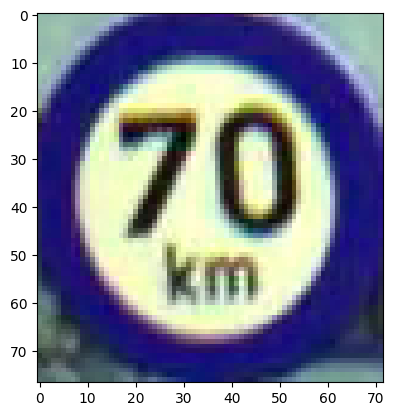

In [ ]:
plt.imshow(img)

In [ ]:
img.shape

(30, 29, 3)

In [ ]:
"/content/Real_Test/CodecError-1/01_01_03_01_0018.bmp".split(".")[0].split("_")[-1]

'0018'

In [ ]:
import json

In [ ]:
f = open("/content/drive/MyDrive/DIP/dataset/CURE_TSR/CURE_TSR_real_final_f.json")
un = json.load(f)

In [ ]:
for i in range(0, len(un["img_name"])):
  print(un["img_name"][i])
  print(un["psnr_d1"][i])
  print(un["ssim_d1"][i])
  print(un["cw-ssim_d1"][i])
  print(un["psnr_d2"][i])
  print(un["ssim_d2"][i])
  print(un["cw-ssim_d2"][i])

In [ ]:
new_res = {
    "img_name": un["img_name"],
    "psnr_d1" : un["psnr_d1"],
    "ssim_d1": un["ssim_d1"],
    "cw-ssim_d1": [],
    "psnr_d2" : un["psnr_d2"],
    "ssim_d2": un["ssim_d2"],
    "cw-ssim_d2": [],
}

for i in range(0, len(un["img_name"])):
  img_path = "/content/drive/MyDrive/DIP/dataset/CURE_TSR/r1/" + un["img_name"][i].split(".")[0]
  img1 = cv2.imread(img_path + "/original.png")
  d1 = cv2.imread(img_path + "/d1.png")
  d2 = cv2.imread(img_path + "/d2.png")
  new_res["cw-ssim_d1"].append(cal_cw_ssim(img1, d1))
  new_res["cw-ssim_d2"].append(cal_cw_ssim(img1, d2))
  # print(cal_cw_ssim(img1, d1))
  # print(cal_cw_ssim(img1, d2))

In [ ]:
with open("/content/drive/MyDrive/DIP/dataset/CURE_TSR_real_final_f_new_correct.json", "w") as write_file:
        json.dump(new_res, write_file)

In [ ]:
j = []
for i in range(0, len(un["img_name"])):
  # print(un["img_name"][i].split("_")[0])
  if un["img_name"][i].split("_")[0] in j:
    continue
  j.append(un["img_name"][i].split("_")[0])

In [ ]:
j

In [ ]:
len(j)*100

6000

In [ ]:
len(un["img_name"])

6000